In [1]:
import matplotlib.pyplot as plt
import numpy as np
import wave1D.configuration as configuration
import wave1D.finite_element_space as fe_sp
import wave1D.finite_element_operator as fe_op
import wave1D.elastic_propagator as elastic_propagator
import wave1D.lagrange_polynomial as lag_poly
import wave1D.mass_assembler as mass_assembler
import wave1D.mesh as mesh
import wave1D.stiffness_assembler as stiffness_assembler

% matplotlib inline

# Description of a model problem and its analytical solution

We consider the following 1D problem

\begin{equation*}
\left\lbrace
\begin{aligned}
& \partial^2_{tt} u - \partial^2_{xx}u= 0,\quad \text{in }]0; 1[,\\
& \partial_x u = 0,\quad \text{at } x \in \{0, 1\},\\
& u(\cdot, 0) = u_0,\quad \partial_tu(\cdot, 0) = u_1,
\end{aligned}
\right.
\end{equation*}

from which we extract analytical solution using a spectral approach. We consider the family of orthonormal eigen functions $\{e_i\}_{i\in\mathbb{N}^*}$ solution of 

\begin{equation*}
\left\lbrace
\begin{aligned}
& - \partial^2_{xx} e_i= \lambda_i e_i,\quad \text{in }]0; 1[,\\
& \partial_x e_i = 0,\quad \text{at } x \in \{0, 1\}.
\end{aligned}
\right.
\end{equation*}

After standard calculus, one can verify that

\begin{equation*}
\lambda_i = i^2\pi^2, \quad e_i(x) = \sqrt{2}cos(i\pi x), \quad \forall i \in \mathbb{N}^*.
\end{equation*}

Decomposing the solution $u(x, t)$ in this basis

\begin{equation*}
u(x, t) = \sum_{i \in\mathbb{N}^*} \xi_i(t) e_i(x),
\end{equation*}

we obtain the following set of ordinary differential equations

\begin{equation*}
\left\lbrace
\begin{aligned}
& \mathrm{d}^2_{tt} \xi_i + \lambda_i\xi_i = 0,\quad \text{in }]0; 1[,\\
& \xi_i(0) = (u_0, e_i)_{L^2(]0; 1[)},\quad \mathrm{d}_t\xi_i(0) = (u_1, e_i)_{L^2(]0; 1[)}.
\end{aligned}
\right.
\end{equation*},

that can be solved explicitly


\begin{equation*}
\xi_i(t) = (u_0, e_i)_{L^2(]0; 1[)} cos(i\pi t) + \frac{1}{\omega} (u_1, e_i)_{L^2(]0; 1[)} sin(i\pi t), \quad \forall i \in \mathbb{N}^*.
\end{equation*}

In the following, we will typically choose a spatially frequency $\kappa$ such that

\begin{equation*}
u_0 = e_\kappa, \quad u_1 = 0, 
\end{equation*}

so that finally we obtain

\begin{equation*}
u_\kappa(x, t) = \sqrt{2} cos(\kappa\pi t) cos(\kappa\pi x).
\end{equation*}


In [2]:
def analytical_solution(k, x, t):
    return [np.sqrt(2.0) * np.cos(k * np.pi * t) * np.cos(k * np.pi * xx) for xx in x]

# Convergence Equally Distributed & Assembled

In [38]:
def make_propagator(k, nelem, fe_order, fe_basis, quad_order, quad_type, mass_type, stiff_type, timestep=None, cfl_factor=None):
        
    # Creating mesh.
    msh = mesh.make_mesh_from_npt(0.0, 1.0, nelem + 1)
    
    # Creating finite element space.
    fe_space = fe_sp.FiniteElementSpace(msh, fe_order=fe_order, basis_type=fe_basis, quad_order=quad_order, quad_type=quad_type)
    
    # Creating configuration.
    config = configuration.Elastic(init_field=lambda x: np.sqrt(2.0) * np.cos(k * np.pi * x))

    # Creating propagator.
    numerical_propagator = elastic_propagator.ElasticExplicitOrderTwo(config, fe_space,
          init_cond_type=elastic_propagator.InitialConditionType.ORDERTWO,
          mass_assembly_type=mass_type,
          stiffness_assembly_type=stiff_type)
    
    # Initializing propagator.
    numerical_propagator.initialize(timestep, cfl_factor)
    
    return numerical_propagator

In [81]:
def make_equally_distributed_assembled_propagator(k, nelem, fe_order, timestep=None, cfl_factor=None):
    
    return make_propagator(k, nelem, 
            fe_order, lag_poly.PointDistributionType.EQUALLY_DISTRIBUTED,
            2 * fe_order, lag_poly.PointDistributionType.EQUALLY_DISTRIBUTED,
            fe_op.AssemblyType.ASSEMBLED, fe_op.AssemblyType.ASSEMBLED, timestep, cfl_factor)

def make_gauss_lobatto_assembled_propagator(k, nelem, fe_order, timestep=None, cfl_factor=None):
    
    return make_propagator(k, nelem, 
            fe_order, lag_poly.PointDistributionType.GAUSS_LOBATTO,
            fe_order + 1, lag_poly.PointDistributionType.GAUSS_LOBATTO,
            fe_op.AssemblyType.ASSEMBLED, fe_op.AssemblyType.ASSEMBLED, timestep, cfl_factor)

def make_gauss_lobatto_lumped_propagator(k, nelem, fe_order, timestep=None, cfl_factor=None):
    
    return make_propagator(k, nelem, 
            fe_order, lag_poly.PointDistributionType.GAUSS_LOBATTO,
            fe_order, lag_poly.PointDistributionType.GAUSS_LOBATTO,
            fe_op.AssemblyType.LUMPED, fe_op.AssemblyType.ASSEMBLED, timestep, cfl_factor)

def make_equally_distributed_lumped_propagator(k, nelem, fe_order, timestep=None, cfl_factor=None):
    
    return make_propagator(k, nelem, 
            fe_order, lag_poly.PointDistributionType.EQUALLY_DISTRIBUTED,
            fe_order, lag_poly.PointDistributionType.EQUALLY_DISTRIBUTED,
            fe_op.AssemblyType.LUMPED, fe_op.AssemblyType.ASSEMBLED, timestep, cfl_factor)

In [53]:
class Errors:
    def __init__(self):
        self.l2_l2 = []
        self.l2_h1 = []
        self.linf_l2 = []
        self.linf_h1 = []

In [88]:
def comput_errors(propagator_builder_type, k, fe_order, nelems, tmax, cfl_factor=None):

    errors = Errors()

    # Extracting minimal timestep and number of steps
    timestep = None
    if propagator_builder_type is 'equally_distributed_assembled':
        timestep = make_equally_distributed_assembled_propagator(k, nelems[-1], fe_order, cfl_factor=cfl_factor).timestep
    elif propagator_builder_type is 'gauss_lobatto_assembled':
        timestep = make_gauss_lobatto_assembled_propagator(k, nelems[-1], fe_order, cfl_factor=cfl_factor).timestep
    elif propagator_builder_type is 'gauss_lobatto_lumped':
        timestep = make_gauss_lobatto_lumped_propagator(k, nelems[-1], fe_order, cfl_factor=cfl_factor).timestep
    elif propagator_builder_type is 'equally_distributed_lumped':
        timestep = make_equally_distributed_lumped_propagator(k, nelems[-1], fe_order, cfl_factor=cfl_factor).timestep
        
    # Computing number of time steps.
    nstep = int(np.ceil(tmax / timestep))

    # Runing propagators for every discretization.
    for nelem in nelems:

        # Creating propagator.
        propagator = None
        if propagator_builder_type is 'equally_distributed_assembled':
            propagator = make_equally_distributed_assembled_propagator(k, nelem, fe_order, timestep=timestep)
        elif propagator_builder_type is 'gauss_lobatto_assembled':
            propagator = make_gauss_lobatto_assembled_propagator(k, nelem, fe_order, timestep=timestep)
        elif propagator_builder_type is 'gauss_lobatto_lumped':
            propagator = make_gauss_lobatto_lumped_propagator(k, nelem, fe_order, timestep=timestep)
        elif propagator_builder_type is 'equally_distributed_lumped':
            propagator = make_equally_distributed_lumped_propagator(k, nelem, fe_order, timestep=timestep)

        # Extracting DoF coordinates.
        dof_coords = propagator.fe_space.get_dof_coords()

        # Initializing error values.
        linf_l2_err_n = 0.0
        linf_h1_err_n = 0.0
        l2_l2_err_n = 0.0
        l2_h1_err_n = 0.0

        # Computing mass and stiffness matrices for error computations.
        mass = mass_assembler.assemble_mass(propagator.fe_space, assembly_type=fe_op.AssemblyType.ASSEMBLED)
        stiffness = stiffness_assembler.assemble_stiffness(propagator.fe_space, assembly_type=fe_op.AssemblyType.ASSEMBLED)

        # Running propagator & computing errors.
        for i in range(nstep):

            # Forwarding numerical model.
            propagator.forward()

            # Computing analytical solution.
            analytical_sol = analytical_solution(k, dof_coords, (i + 1) * propagator.timestep)

            # Computing difference between exact & numerical solution.
            delta_sol = analytical_sol - propagator.u1

            # Computing l2 & h1 space errors.
            l2_err = np.sqrt(fe_op.apply_as_linear_form(mass, delta_sol, delta_sol))
            h1_err = np.sqrt(l2_err ** 2 + fe_op.apply_as_linear_form(stiffness, delta_sol, delta_sol))

            # Computing time errors.
            linf_l2_err_n = max(linf_l2_err_n, l2_err)
            linf_h1_err_n = max(linf_h1_err_n, h1_err)
            l2_l2_err_n += propagator.timestep * (l2_err ** 2)
            l2_h1_err_n += propagator.timestep * (h1_err ** 2)

            # Swapping model.
            propagator.swap()

        # Storing error values.
        errors.l2_l2.append(np.sqrt(l2_l2_err_n))
        errors.l2_h1.append(np.sqrt(l2_h1_err_n))
        errors.linf_l2.append(linf_l2_err_n)
        errors.linf_h1.append(linf_h1_err_n)
        
    # Returning computed errors.
    return errors

In [59]:
k = 10
tmax = 0.125
nelems = range(11, 50)
errors_order3_equally_distributed_assembled = comput_errors('equally_distributed_assembled', k, 3, nelems, tmax, cfl_factor=0.01)
errors_order4_equally_distributed_assembled = comput_errors('equally_distributed_assembled', k, 4, nelems, tmax, cfl_factor=0.01)
errors_order5_equally_distributed_assembled = comput_errors('equally_distributed_assembled', k, 5, nelems, tmax, cfl_factor=0.01)

errors_order3_gauss_lobatto_assembled = comput_errors('gauss_lobatto_assembled', k, 3, nelems, tmax, cfl_factor=0.01)
errors_order4_gauss_lobatto_assembled = comput_errors('gauss_lobatto_assembled', k, 4, nelems, tmax, cfl_factor=0.01)
errors_order5_gauss_lobatto_assembled = comput_errors('gauss_lobatto_assembled', k, 5, nelems, tmax, cfl_factor=0.01)

errors_order3_gauss_lobatto_lumped = comput_errors('gauss_lobatto_lumped', k, 3, nelems, tmax, cfl_factor=0.01)
errors_order4_gauss_lobatto_lumped = comput_errors('gauss_lobatto_lumped', k, 4, nelems, tmax, cfl_factor=0.01)
errors_order5_gauss_lobatto_lumped = comput_errors('gauss_lobatto_lumped', k, 5, nelems, tmax, cfl_factor=0.01)

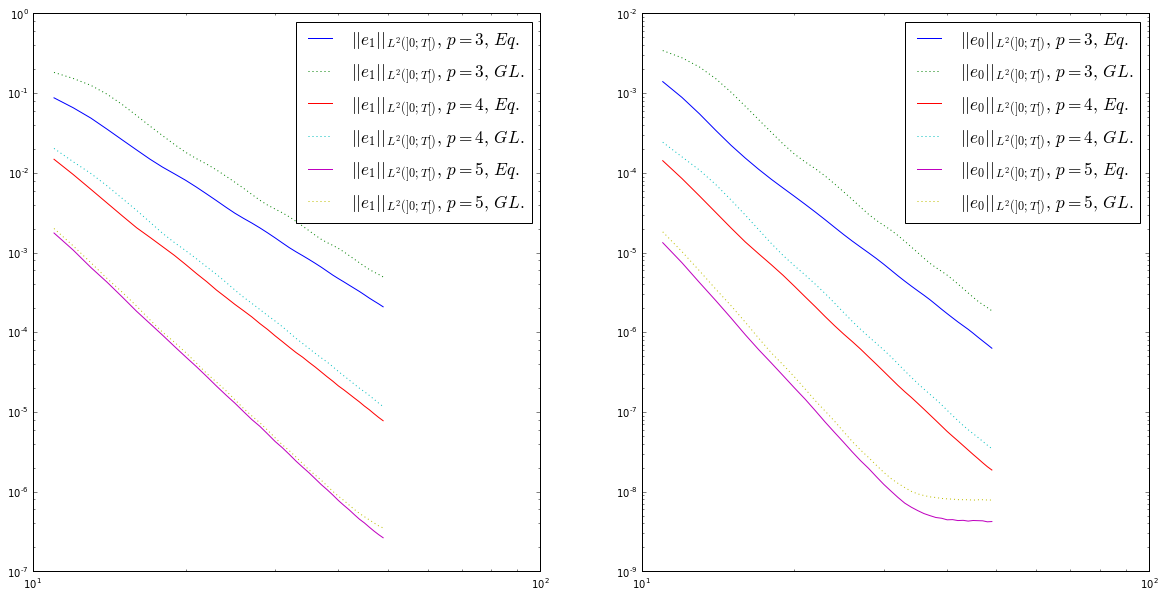

In [60]:
fig = plt.figure(figsize=(20, 10))

ax = fig.add_subplot(1, 2, 1)
ax.loglog(nelems, errors_order3_gauss_lobatto_assembled.l2_h1, label="$|| e_1 ||_{L^2(]0; T[)},\,p=3,\,Eq.$")
ax.loglog(nelems, errors_order3_gauss_lobatto_lumped.l2_h1, label="$|| e_1 ||_{L^2(]0; T[)},\,p=3,\,GL.$", linestyle=':')
ax.loglog(nelems, errors_order4_gauss_lobatto_assembled.l2_h1, label="$|| e_1 ||_{L^2(]0; T[)},\,p=4,\,Eq.$")
ax.loglog(nelems, errors_order4_gauss_lobatto_lumped.l2_h1, label="$|| e_1 ||_{L^2(]0; T[)},\,p=4,\,GL.$", linestyle=':')
ax.loglog(nelems, errors_order5_gauss_lobatto_assembled.l2_h1, label="$|| e_1 ||_{L^2(]0; T[)},\,p=5,\,Eq.$")
ax.loglog(nelems, errors_order5_gauss_lobatto_lumped.l2_h1, label="$|| e_1 ||_{L^2(]0; T[)},\,p=5,\,GL.$", linestyle=':')
ax.legend(loc='upper right', fontsize='xx-large')

ax = fig.add_subplot(1, 2, 2)
ax.loglog(nelems, errors_order3_gauss_lobatto_assembled.l2_l2, label="$|| e_0 ||_{L^2(]0; T[)},\,p=3,\,Eq.$")
ax.loglog(nelems, errors_order3_gauss_lobatto_lumped.l2_l2, label="$|| e_0 ||_{L^2(]0; T[)},\,p=3,\,GL.$", linestyle=':')
ax.loglog(nelems, errors_order4_gauss_lobatto_assembled.l2_l2, label="$|| e_0 ||_{L^2(]0; T[)},\,p=4,\,Eq.$")
ax.loglog(nelems, errors_order4_gauss_lobatto_lumped.l2_l2, label="$|| e_0 ||_{L^2(]0; T[)},\,p=4,\,GL.$", linestyle=':')
ax.loglog(nelems, errors_order5_gauss_lobatto_assembled.l2_l2, label="$|| e_0 ||_{L^2(]0; T[)},\,p=5,\,Eq.$")
ax.loglog(nelems, errors_order5_gauss_lobatto_lumped.l2_l2, label="$|| e_0 ||_{L^2(]0; T[)},\,p=5,\,GL.$", linestyle=':')
ax.legend(loc='upper right', fontsize='xx-large')

In [70]:
print np.polyfit(np.log(nelems[10:20]), np.log(errors_order3_gauss_lobatto_lumped.l2_h1[10:20]), 1)[0]
print np.polyfit(np.log(nelems[10:20]), np.log(errors_order4_gauss_lobatto_lumped.l2_h1[10:20]), 1)[0]
print np.polyfit(np.log(nelems[10:20]), np.log(errors_order5_gauss_lobatto_lumped.l2_h1[10:20]), 1)[0]

-4.213646073
-5.08082841656
-6.0060801861


In [73]:
print np.polyfit(np.log(nelems[10:20]), np.log(errors_order3_gauss_lobatto_lumped.l2_l2[10:20]), 1)[0]
print np.polyfit(np.log(nelems[10:20]), np.log(errors_order4_gauss_lobatto_lumped.l2_l2[10:20]), 1)[0]
print np.polyfit(np.log(nelems[10:20]), np.log(errors_order5_gauss_lobatto_lumped.l2_l2[10:20]), 1)[0]

-5.31208109032
-6.16118576863
-6.7772552398


In [74]:
print np.polyfit(np.log(nelems[10:20]), np.log(errors_order3_gauss_lobatto_assembled.l2_h1[10:20]), 1)[0]
print np.polyfit(np.log(nelems[10:20]), np.log(errors_order4_gauss_lobatto_assembled.l2_h1[10:20]), 1)[0]
print np.polyfit(np.log(nelems[10:20]), np.log(errors_order5_gauss_lobatto_assembled.l2_h1[10:20]), 1)[0]

-4.06493441949
-4.99421229443
-6.01390173956


In [75]:
print np.polyfit(np.log(nelems[10:20]), np.log(errors_order3_gauss_lobatto_assembled.l2_l2[10:20]), 1)[0]
print np.polyfit(np.log(nelems[10:20]), np.log(errors_order4_gauss_lobatto_assembled.l2_l2[10:20]), 1)[0]
print np.polyfit(np.log(nelems[10:20]), np.log(errors_order5_gauss_lobatto_assembled.l2_l2[10:20]), 1)[0]

-4.85235677346
-5.99094594948
-6.8830429424


In [76]:
print np.polyfit(np.log(nelems[10:20]), np.log(errors_order3_equally_distributed_assembled.l2_h1[10:20]), 1)[0]
print np.polyfit(np.log(nelems[10:20]), np.log(errors_order4_equally_distributed_assembled.l2_h1[10:20]), 1)[0]
print np.polyfit(np.log(nelems[10:20]), np.log(errors_order5_equally_distributed_assembled.l2_h1[10:20]), 1)[0]

-3.12121207052
-4.01762739065
-5.01213480488


In [77]:
print np.polyfit(np.log(nelems[10:20]), np.log(errors_order3_equally_distributed_assembled.l2_l2[10:20]), 1)[0]
print np.polyfit(np.log(nelems[10:20]), np.log(errors_order4_equally_distributed_assembled.l2_l2[10:20]), 1)[0]
print np.polyfit(np.log(nelems[10:20]), np.log(errors_order5_equally_distributed_assembled.l2_l2[10:20]), 1)[0]

-4.28917803753
-4.97404207314
-6.05529917211


In [80]:
k = 10
tmax = 0.125
nelems = range(11, 30)
errors_order6_equally_distributed_assembled = comput_errors('equally_distributed_assembled', k, 6, nelems, tmax, cfl_factor=0.01)
errors_order7_equally_distributed_assembled = comput_errors('equally_distributed_assembled', k, 7, nelems, tmax, cfl_factor=0.01)
errors_order8_equally_distributed_assembled = comput_errors('equally_distributed_assembled', k, 8, nelems, tmax, cfl_factor=0.01)

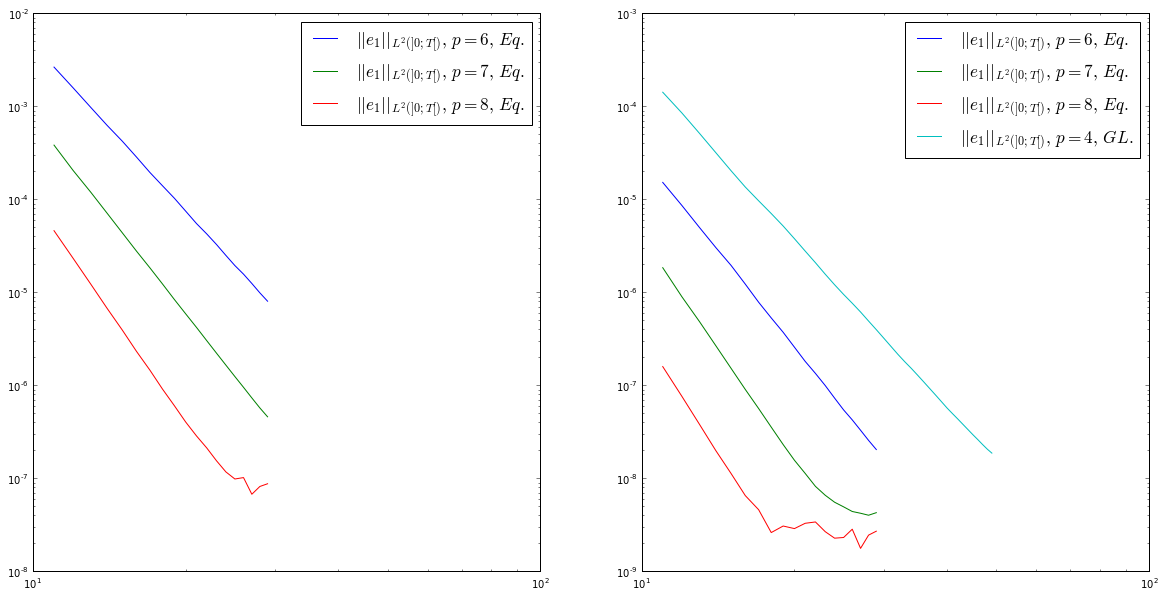

In [103]:
fig = plt.figure(figsize=(20, 10))

ax = fig.add_subplot(1, 2, 1)
ax.loglog( range(11, 30), errors_order6_equally_distributed_assembled.l2_h1, label="$|| e_1 ||_{L^2(]0; T[)},\,p=6,\,Eq.$")
ax.loglog( range(11, 30), errors_order7_equally_distributed_assembled.l2_h1, label="$|| e_1 ||_{L^2(]0; T[)},\,p=7,\,Eq.$")
ax.loglog( range(11, 30), errors_order8_equally_distributed_assembled.l2_h1, label="$|| e_1 ||_{L^2(]0; T[)},\,p=8,\,Eq.$")
ax.legend(loc='upper right', fontsize='xx-large')

ax = fig.add_subplot(1, 2, 2)
ax.loglog( range(11, 30), errors_order6_equally_distributed_assembled.l2_l2, label="$|| e_1 ||_{L^2(]0; T[)},\,p=6,\,Eq.$")
ax.loglog( range(11, 30), errors_order7_equally_distributed_assembled.l2_l2, label="$|| e_1 ||_{L^2(]0; T[)},\,p=7,\,Eq.$")
ax.loglog( range(11, 30), errors_order8_equally_distributed_assembled.l2_l2, label="$|| e_1 ||_{L^2(]0; T[)},\,p=8,\,Eq.$")
ax.loglog( range(11, 50), errors_order4_gauss_lobatto_assembled.l2_l2, label="$|| e_1 ||_{L^2(]0; T[)},\,p=4,\,GL.$")

ax.legend(loc='upper right', fontsize='xx-large')

In [86]:
print np.polyfit(np.log(nelems[10:20]), np.log(errors_order6_equally_distributed_assembled.l2_h1[10:20]), 1)[0]
print np.polyfit(np.log(nelems[10:20]), np.log(errors_order7_equally_distributed_assembled.l2_h1[10:20]), 1)[0]
print np.polyfit(np.log(nelems[10:20]), np.log(errors_order8_equally_distributed_assembled.l2_h1[10:20]), 1)[0]

-5.98748615558
-6.88488195994
-3.95737990243


In [90]:
k = 10
tmax = 0.125
nelems = range(11, 50)
errors_order3_equally_distributed_lumped = comput_errors('equally_distributed_lumped', k, 3, nelems, tmax, cfl_factor=0.01)
errors_order4_equally_distributed_lumped = comput_errors('equally_distributed_lumped', k, 4, nelems, tmax, cfl_factor=0.01)
errors_order5_equally_distributed_lumped = comput_errors('equally_distributed_lumped', k, 5, nelems, tmax, cfl_factor=0.01)

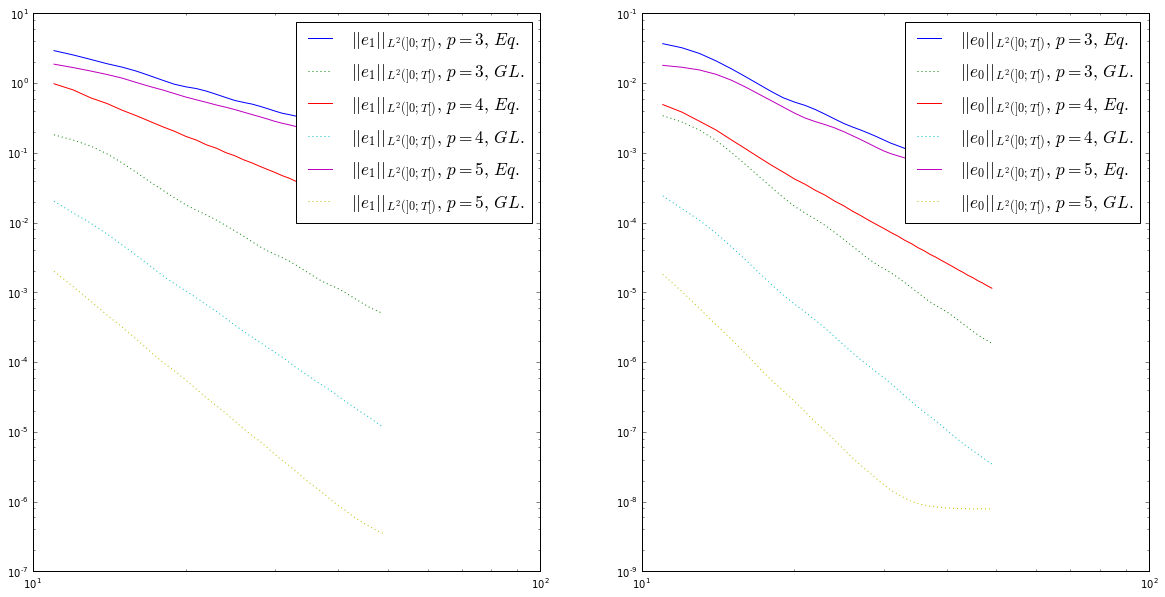

In [107]:
fig = plt.figure(figsize=(20, 10))

fig = plt.figure(figsize=(20, 10))

ax = fig.add_subplot(1, 2, 1)
ax.loglog(nelems, errors_order3_equally_distributed_lumped.l2_h1, label="$|| e_1 ||_{L^2(]0; T[)},\,p=3,\,Eq.$")
ax.loglog(nelems, errors_order3_gauss_lobatto_lumped.l2_h1, label="$|| e_1 ||_{L^2(]0; T[)},\,p=3,\,GL.$", linestyle=':')
ax.loglog(nelems, errors_order4_equally_distributed_lumped.l2_h1, label="$|| e_1 ||_{L^2(]0; T[)},\,p=4,\,Eq.$")
ax.loglog(nelems, errors_order4_gauss_lobatto_lumped.l2_h1, label="$|| e_1 ||_{L^2(]0; T[)},\,p=4,\,GL.$", linestyle=':')
ax.loglog(nelems, errors_order5_equally_distributed_lumped.l2_h1, label="$|| e_1 ||_{L^2(]0; T[)},\,p=5,\,Eq.$")
ax.loglog(nelems, errors_order5_gauss_lobatto_lumped.l2_h1, label="$|| e_1 ||_{L^2(]0; T[)},\,p=5,\,GL.$", linestyle=':')
ax.legend(loc='upper right', fontsize='xx-large')

ax = fig.add_subplot(1, 2, 2)
ax.loglog(nelems, errors_order3_equally_distributed_lumped.l2_l2, label="$|| e_0 ||_{L^2(]0; T[)},\,p=3,\,Eq.$")
ax.loglog(nelems, errors_order3_gauss_lobatto_lumped.l2_l2, label="$|| e_0 ||_{L^2(]0; T[)},\,p=3,\,GL.$", linestyle=':')
ax.loglog(nelems, errors_order4_equally_distributed_lumped.l2_l2, label="$|| e_0 ||_{L^2(]0; T[)},\,p=4,\,Eq.$")
ax.loglog(nelems, errors_order4_gauss_lobatto_lumped.l2_l2, label="$|| e_0 ||_{L^2(]0; T[)},\,p=4,\,GL.$", linestyle=':')
ax.loglog(nelems, errors_order5_equally_distributed_lumped.l2_l2, label="$|| e_0 ||_{L^2(]0; T[)},\,p=5,\,Eq.$")
ax.loglog(nelems, errors_order5_gauss_lobatto_lumped.l2_l2, label="$|| e_0 ||_{L^2(]0; T[)},\,p=5,\,GL.$", linestyle=':')
ax.legend(loc='upper right', fontsize='xx-large')